# Kakao Bank Data Analysis Project
- Author: Daeun Hwang
- Topic: Evaluating the Impact of COVID-19 on Delinquency Rates
- Analysis Method: Using a logistic model trained on data from 2017-2019 to predict delinquency in 2020. If the predictions differ from actual outcomes, analyze which groups deviate from the predictions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
mpl.rcParams['axes.unicode_minus'] = False
palette = sns.color_palette("bright")
plt.rcParams["font.family"] = 'Nanum Gothic TTF'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (14,4)
path = 'NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

# 0. Creating The Data Frame

In [ ]:
df20 = pd.read_csv('./data/hhdata2020.csv', engine = 'python')
df20 = df20.dropna(subset = ['원리금연체유무']) # Keep Only Rows Where Delinquency Status Variable is Not Null
df_code = pd.read_excel('./data/code2020.xlsx', sheet_name = '코드설명서', header = 2, usecols='B:G')

In [3]:
# Remove Variables Present in 2017 and 2018 Data but Absent in 2019 and 2020 Data
miss_col17 = ['조사부문코드', '가중값(금융부문)','가중값(복지부문)','과거기준입주형태통합코드', '소득5분위코드(금융부문)(보완)','소득5분위코드(복지부문)(보완)',
              '자산총액5분위코드(금융부문)', '자산총액5분위코드(복지부문)','순자산5분위코드(금융부문)','순자산5분위코드(금융부문).1','금융자산투자주목적코드']

In [4]:
df17 = pd.read_csv('./data/hhdata2017.csv', engine = 'python').drop(miss_col17, axis=1)
df17.columns = df20.columns
df17 = df17.dropna(subset = ['원리금연체유무'])
df18 = pd.read_csv('./data/hhdata2018.csv', engine = 'python').drop(miss_col17, axis=1)
df18.columns = df20.columns
df18 = df18.dropna(subset = ['원리금연체유무'])               
df19 = pd.read_csv('./data/hhdata2019.csv', engine = 'python')
df19 = df19.dropna(subset = ['원리금연체유무'])
df19.columns = df20.columns

In [5]:
df_col = pd.DataFrame(df20.columns, range(1,len(df20.columns)+1), columns = ['변수'])
df_code = df_code.fillna(method='ffill').set_index('일련\n번호')
df_code = pd.merge(df_col, df_code, left_index = True, right_index = True).drop(['내용'], axis = 1) # Match Variable Names Between Codebook and Data
df_code2 = pd.read_excel('./data/code2017.xlsx', sheet_name = '코드설명서', header = 2, usecols='C:G') # UseCodebook for 2017 and 2018 Data

In [111]:
df_ind = pd.read_excel('./data/code2020.xlsx', sheet_name = '산업분류(10차)', header = 2, nrows = 21, usecols='A:B') 
df_ind = df_ind.append({'대분류':'무직', '분류명':'무직'}, ignore_index = True)

# 1. Data Preprocessing
## (1) Handling Missing Values

In [7]:
missing17 = pd.DataFrame(df17.isnull().sum(), columns = ['missing'])
missing_col = missing17[missing17['missing']!=0].index

In [8]:
missing17.T[missing_col]

,가구주_교육정도_수학구분코드,가구주_산업대분류코드,가구주_직업대분류코드,지출_소비지출,지출_소비지출_식료품(외식비포함),지출_소비지출_주거비,지출_소비지출_교육비(보육료포함),지출_소비지출_의료비,지출_소비지출_교통비,지출_소비지출_통신비,...,원리금상환기인가계지출감소항목코드,부채상환가능시기코드,가구주_은퇴여부,가구주_미은퇴_은퇴연령,가구주_미은퇴_최소생활비,가구주_미은퇴_적정생활비,가구주_미은퇴_노후준비상황코드,가구주_은퇴실제연령,가구주_은퇴_적정생활비충당여부,가구주은퇴_생활비재원마련코드(2014년~)
missing,94,576,576,5009,5009,5009,5009,5009,5009,5009,...,2441,1,5009,5009,5009,5009,5009,5009,5009,5009


- Reason for missing values in the household head's major industry classification code: retirement or unemployment.

In [9]:
df17[df17['가구주_산업대분류코드'].isnull() & (df17['보도용_가구주종사상지위코드']!='G4')]

,기준년도,MD제공용_가구고유번호,가중값,수도권여부,가구주_성별코드,가구원수,노인가구코드,조손가구코드,한부모가구코드,다문화가구(2012년~),...,원리금상환기인가계지출감소항목코드,부채상환가능시기코드,가구주_은퇴여부,가구주_미은퇴_은퇴연령,가구주_미은퇴_최소생활비,가구주_미은퇴_적정생활비,가구주_미은퇴_노후준비상황코드,가구주_은퇴실제연령,가구주_은퇴_적정생활비충당여부,가구주은퇴_생활비재원마련코드(2014년~)


In [10]:
dflist = [df17, df18, df19, df20]

In [18]:
miss_col = []
for x in range(len(dflist)):
    dflist[x]['가구주_산업대분류코드'] = dflist[x]['가구주_산업대분류코드'].fillna('무직')
    dflist[x]['원리금연체유무'] = dflist[x]['원리금연체유무'].replace(2,0)
    missing = pd.DataFrame(dflist[x].isnull().sum(), columns = ['missing'])
    miss_col.extend(missing[missing['missing']!=0].index)
miss_col = list(set(miss_col))
for x in range(len(dflist)):
    dflist[x] = dflist[x].drop(miss_col, axis =1)
df17 = dflist[0]
df18 = dflist[1]
df19 = dflist[2]
df20 = dflist[3]

In [ ]:
miss_col # Removed Variables

# 2. Descriptive Statistics

In [ ]:
# Delinquency Rate by Year
plt.figure()
bar = plt.bar(['2017','2018','2019','2020'],[df17['원리금연체유무'].mean(),df18['원리금연체유무'].mean(),
                                       df19['원리금연체유무'].mean(),df20['원리금연체유무'].mean()], color = 'gold')
for x in bar:
    h = x.get_height()
    plt.text(x.get_x()+x.get_width()/2,h-0.05, ha='center',s=round(h,2), size = 20)
plt.title('연도별 연체율')
plt.savefig('./fig/연도별 연체율.png')
plt.show()


In [114]:
#discrete
def bar_chart(feature, year):
    df = dflist[year]
    yes = df[df['원리금연체유무']==1][feature].value_counts()
    no = df[df['원리금연체유무']==0][feature].value_counts()
    df_p = pd.DataFrame([yes, no]).sort_index(axis =1)
    df_p = df_p.div(df_p.sum(axis=0), axis =1)
    df_p.index = ['연체O', '연체X']
    if feature == '가구주_산업대분류코드':
        df_p.columns = df_ind['분류명']
        df_p = df_p.T.sort_values(by='연체O', ascendiing =False).T.iloc[:,:5]
    else:
        df_p.columns = df_code[df_code['변수']==feature]['코드설명'].to_list()
    df_p.T.plot(kind='bar', stacked = True, figsize = (10,5), colormap='cividis')
    plt.title(f'{year+2017}년 {feature}에 따른 원리금 연체 유무')
    
    return df_p

,소득1분위,소득2분위,소득3분위,소득4분위,소득5분위
연체O,0.194981,0.142782,0.107143,0.072294,0.064877
연체X,0.805019,0.857218,0.892857,0.927706,0.935123


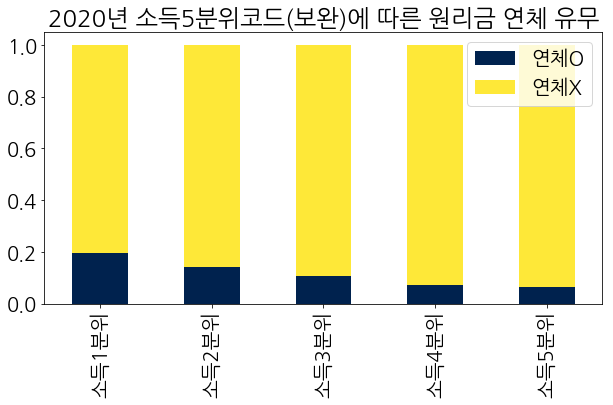

In [84]:
bar_chart('소득5분위코드(보완)', 3)

,30세 미만,30~40세 미만,40~50세 미만,50~60세 미만,60세이상
연체O,0.11215,0.082869,0.113682,0.123077,0.091694
연체X,0.88785,0.917131,0.886318,0.876923,0.908306


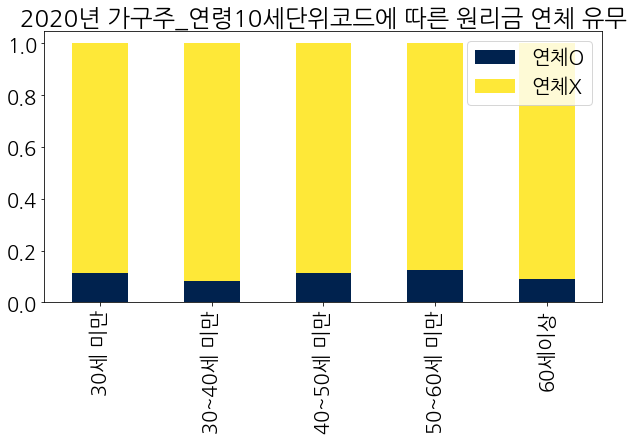

In [85]:
bar_chart('가구주_연령10세단위코드',3)

분류명,"농업, 임업 및 어업",광업,제조업,"전기, 가스, 증기 및 공기조절 공급업","수도, 하수 및 폐기물 처리, 원료 재생업",건설업,도매 및 소매업,운수 및 창고업,숙박 및 음식점업,정보통신업,...,"전문, 과학 및 기술 서비스업","사업시설관리, 사업지원 및 임대 서비스업","공공행정, 국방 및 사회보장 행정",교육 서비스업,보건업 및 사회복지 서비스업,"예술, 스포츠 및 여가관련 서비스업","협회 및 단체, 수리 및 기타 개인 서비스업",가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동,국제 및 외국기관,무직
연체O,0.088768,0.166667,0.093357,0.02,0.021277,0.141799,0.115213,0.097403,0.12731,0.064103,...,0.067568,0.105618,0.052133,0.08802,0.083333,0.13913,0.117143,0.076923,NaN,0.14132
연체X,0.911232,0.833333,0.906643,0.98,0.978723,0.858201,0.884787,0.902597,0.87269,0.935897,...,0.932432,0.894382,0.947867,0.91198,0.916667,0.86087,0.882857,0.923077,1.0,0.85868


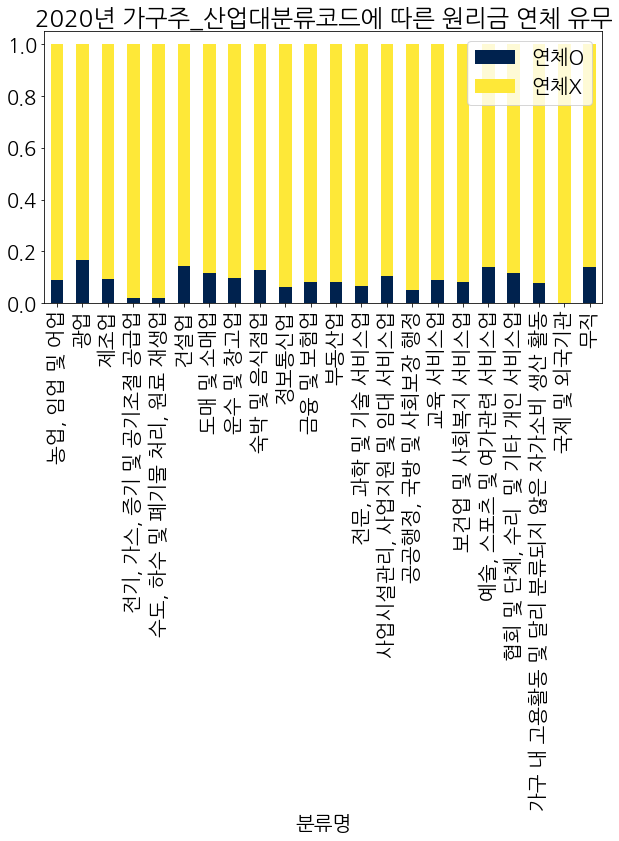

In [115]:
bar_chart('가구주_산업대분류코드',3)

,감소하였다,변화 없었다,증가하였다
연체O,0.076887,0.098979,0.15406
연체X,0.923113,0.901021,0.84594


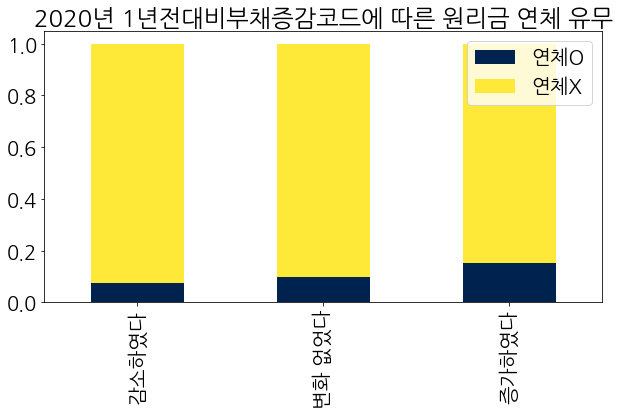

In [116]:
bar_chart('1년전대비부채증감코드',3)

,안 받음(미취학 포함),초등학교,중학교,고등학교,대학(3년제 이하),대학교(4년제 이상),대학원석사,대학원박사 이상
연체O,0.135922,0.102964,0.129181,0.126219,0.111028,0.074557,0.085603,0.077519
연체X,0.864078,0.897036,0.870819,0.873781,0.888972,0.925443,0.914397,0.922481


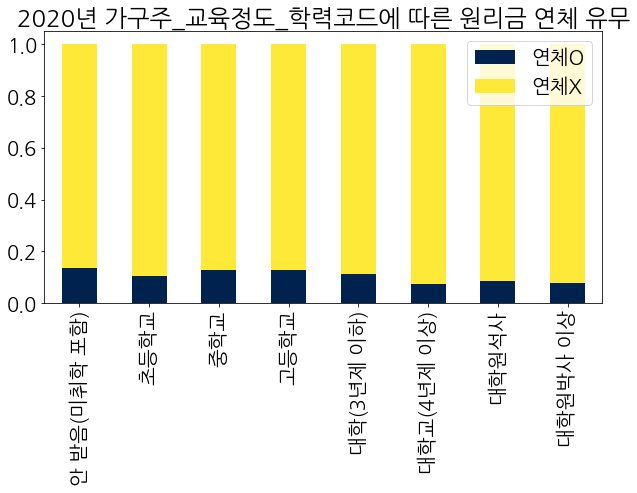

In [117]:
bar_chart('가구주_교육정도_학력코드',3)

In [ ]:
#이전과 달라진 변수
def make_df(feature,year):
    df = dflist[year]
    yes = df[df['원리금연체유무']==1][feature].value_counts()
    no = df[df['원리금연체유무']==0][feature].value_counts()
    df_p = pd.DataFrame([yes, no]).sort_index(axis =1)
    df_p = df_p.div(df_p.sum(axis=0), axis =1)
    df_p.index = ['연체O', '연체X']
    if feature == '가구주_산업대분류코드':
        df_p.columns = df_ind['분류명']
        df_p = df_p.T.sort_values(by='연체O', ascendiing =False).T.iloc[:,:5]
    else:
        df_p.columns = df_code[df_code['변수']==feature]['코드설명'].to_list()
def compare_bar(feature):
    diff = make_df(feature,3)-make_df(feature,2)
    diff.T['연체O'].plot(kind='bar', stacked = True, figsize = (10,5), colormap='cividis')
    plt.title(f'2019년 대비 2020년 {feature}에 따른 연체율 증감정도')

bar_chart('소득5분위코드(보완)')

# 3. Classification

## (1) Preprocessing of Categorical and Continuous Variables

In [119]:
drop_col = ['MD제공용_가구고유번호','가중값','소득계층구간코드(보도용)(보완)',
            '가구주_연령10세단위코드','보도용_가구주종사상지위코드','입주형태코드','가구주_교육정도_통합코드']

In [120]:
df = pd.concat([df17, df18, df19, df20]) 
df = df.drop(drop_col,axis=1)
train = df[df['기준년도']<2020] # Train set : 17-19년도 pooling
test = df[df['기준년도']==2020] # Test set : 20년도

In [121]:
#연속형 변수
conti_col_num = [3, 12] + list(range(22,108))

In [122]:
len(conti_col_num)

88

In [123]:
X_train_conti = train.iloc[:,conti_col_num]
X_train_cate = train.drop(X_train_conti.columns, axis=1).drop('원리금연체유무', axis=1)
y_train = train['원리금연체유무']
X_test_conti = test.iloc[:,conti_col_num]
X_test_cate = test.drop(X_test_conti.columns, axis=1).drop('원리금연체유무', axis=1)
y_test = test['원리금연체유무']

In [124]:
#범주형 원핫인코딩
X_train_cate = pd.get_dummies(X_train_cate, columns = X_train_cate.columns,drop_first = True)
X_test_cate = pd.get_dummies(X_test_cate, columns = X_test_cate.columns, drop_first = True)

In [125]:
X_test_cate['기준년도_2018']=0
X_test_cate['기준년도_2019']=0

In [126]:
# 연속형 전처리 (표준화)_conti
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train_conti)
X_test_std = sc.transform(X_test_conti)

In [127]:
# 번주형, 연속형 합치기
X_train_std = pd.DataFrame(X_train_std, columns = X_train_conti.columns).set_index(X_train_conti.index)
X_test_std = pd.DataFrame(X_test_std, columns = X_test_conti.columns).set_index(X_test_conti.index)
X_train=pd.concat([X_train_cate, X_train_std], axis=1)
X_test=pd.concat([X_test_cate, X_test_std], axis=1)

## (2) Logistic Regression

In [129]:
#Grid Search
from sklearn.model_selection import GridSearchCV
parameters = {"C": [0.001,0.01,0.1,1,10], "penalty":['l1','l2']}
lr = LogisticRegression()
gs = GridSearchCV(lr, parameters, n_jobs=-1, cv=3, scoring="recall")
gs.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.01651187        nan 0.06656347        nan 0.12745098
        nan 0.21001032        nan 0.24251806]
  category=UserWarning
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [130]:
gs.best_score_

0.2425180598555212

In [131]:
gs.best_params_

{'C': 10, 'penalty': 'l2'}

In [132]:
blr = gs.best_estimator_
blr.fit(X_train, y_train)
blr.score(X_test, y_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8946881742525429

In [ ]:
blr.coef_

In [144]:
y_true, y_pred = y_test, blr.predict(X_test)
y_result =pd.DataFrame(y_true)
y_result.columns = ['y_true']
y_result['y_pred']=y_pred
y_incorr = y_result[(y_result['y_pred']==0)& (y_result['y_true']==1)]
pd.merge(y_incorr, df20, left_index = True, right_index = True)

,y_true,y_pred,기준년도,MD제공용_가구고유번호,가중값,수도권여부,가구주_성별코드,가구원수,노인가구코드,조손가구코드,...,지출_비소비지출_연간지급이자(조사),여유자금운용계획코드,금융자산투자운용방법코드,금융자산투자고려사항코드,거주지주택가격전망코드,여유자금부동산투자여부,1년후금융부채규모전망코드,1년전대비부채증감코드,원리금연체유무,원리금상환생계부담정도코드
1,1.0,0.0,2020,10000132,1314.119926,G1,2,2,G2,G2,...,500,3,1,3,1,1,1,1.0,1.0,2.0
32,1.0,0.0,2020,10601111,2318.714812,G1,1,6,G2,G2,...,0,3,1,3,2,1,1,2.0,1.0,3.0
58,1.0,0.0,2020,10800321,1633.067002,G1,1,1,G2,G2,...,0,3,1,2,2,1,1,1.0,1.0,2.0
78,1.0,0.0,2020,10900371,2502.345724,G1,2,4,G2,G2,...,0,3,1,2,2,1,1,1.0,1.0,3.0
90,1.0,0.0,2020,11000302,2761.549409,G1,1,5,G2,G2,...,854,3,1,2,2,1,3,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17969,1.0,0.0,2020,982900301,1397.296816,G2,1,4,G2,G2,...,2904,3,7,1,1,2,3,3.0,1.0,3.0
18006,1.0,0.0,2020,990700331,435.136995,G2,1,4,G2,G2,...,6,3,1,2,1,2,1,3.0,1.0,3.0
18015,1.0,0.0,2020,990800301,530.216993,G2,1,4,G2,G2,...,328,2,1,1,4,1,2,2.0,1.0,3.0
18022,1.0,0.0,2020,990900241,200.916447,G2,1,4,G2,G2,...,205,3,1,2,1,2,1,1.0,1.0,2.0


In [137]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      8706
         1.0       0.62      0.00      0.01      1027

    accuracy                           0.89      9733
   macro avg       0.76      0.50      0.48      9733
weighted avg       0.87      0.89      0.85      9733



## (3) Random Forest

In [262]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1, stratify = y)

In [300]:
y_true, y_pred = y_test, forest.predict(X_test)

In [135]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion = 'gini', n_estimators =25, random_state =1, n_jobs=2)
forest.fit(X_train, y_train)

# plot_decision_regions(df.drop('원리금연체유무', axis=1), df['원리금연체유무'], classifier=forest, test_idx = range(9733,-1))
# plt.show

RandomForestClassifier(n_estimators=25, n_jobs=2, random_state=1)

In [143]:
yrf_true, yrf_pred = y_test, forest.predict(X_test)
yrf_result =pd.DataFrame(yrf_true)
yrf_result.columns = ['y_true']
yrf_result['y_pred']=y_pred
yrf_incorr = yrf_result[(yrf_result['y_pred']==0)& (yrf_result['y_true']==1)]
pd.merge(yrf_incorr, df20, left_index = True, right_index = True)

,y_true,y_pred,기준년도,MD제공용_가구고유번호,가중값,수도권여부,가구주_성별코드,가구원수,노인가구코드,조손가구코드,...,지출_비소비지출_연간지급이자(조사),여유자금운용계획코드,금융자산투자운용방법코드,금융자산투자고려사항코드,거주지주택가격전망코드,여유자금부동산투자여부,1년후금융부채규모전망코드,1년전대비부채증감코드,원리금연체유무,원리금상환생계부담정도코드
1,1.0,0.0,2020,10000132,1314.119926,G1,2,2,G2,G2,...,500,3,1,3,1,1,1,1.0,1.0,2.0
32,1.0,0.0,2020,10601111,2318.714812,G1,1,6,G2,G2,...,0,3,1,3,2,1,1,2.0,1.0,3.0
58,1.0,0.0,2020,10800321,1633.067002,G1,1,1,G2,G2,...,0,3,1,2,2,1,1,1.0,1.0,2.0
78,1.0,0.0,2020,10900371,2502.345724,G1,2,4,G2,G2,...,0,3,1,2,2,1,1,1.0,1.0,3.0
90,1.0,0.0,2020,11000302,2761.549409,G1,1,5,G2,G2,...,854,3,1,2,2,1,3,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17969,1.0,0.0,2020,982900301,1397.296816,G2,1,4,G2,G2,...,2904,3,7,1,1,2,3,3.0,1.0,3.0
18006,1.0,0.0,2020,990700331,435.136995,G2,1,4,G2,G2,...,6,3,1,2,1,2,1,3.0,1.0,3.0
18015,1.0,0.0,2020,990800301,530.216993,G2,1,4,G2,G2,...,328,2,1,1,4,1,2,2.0,1.0,3.0
18022,1.0,0.0,2020,990900241,200.916447,G2,1,4,G2,G2,...,205,3,1,2,1,2,1,1.0,1.0,2.0


In [141]:
print(classification_report(yrf_true, yrf_pred))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      8706
         1.0       0.57      0.04      0.07      1027

    accuracy                           0.90      9733
   macro avg       0.73      0.52      0.51      9733
weighted avg       0.86      0.90      0.85      9733



## (4) Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm = SVC()
parameters = {"kernel": ['linear'], "C":[0.01,0.1,1,10], "gamma":[0.01,0.1,1,10]}
gs = GridSearchCV(svm, parameters, n_jobs=-1, cv=2, scoring="recall")
gs.fit(X_train, y_train)

In [ ]:
bsv = gs.best_estimator_
bsv.fit(X_train, y_train)
bsv.score(X_test, y_test)

In [147]:
svc = SVC(kernel = 'rbf', C=1, gamma=1)
svc.fit(X_train, y_train)

SVC(C=1, gamma=1)

In [148]:
ys_true, ys_pred = y_test, svc.predict(X_test)
ys_result =pd.DataFrame(ys_true)
ys_result.columns = ['y_true']
ys_result['y_pred']=ys_pred
ys_incorr = y_result[(ys_result['y_pred']==2)& (ys_result['y_true']==1)]
pd.merge(ys_incorr, df20, left_index = True, right_index = True)

,y_true,y_pred,기준년도,MD제공용_가구고유번호,가중값,수도권여부,가구주_성별코드,가구원수,노인가구코드,조손가구코드,...,지출_비소비지출_연간지급이자(조사),여유자금운용계획코드,금융자산투자운용방법코드,금융자산투자고려사항코드,거주지주택가격전망코드,여유자금부동산투자여부,1년후금융부채규모전망코드,1년전대비부채증감코드,원리금연체유무,원리금상환생계부담정도코드


In [149]:
print(classification_report(ys_true, ys_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      8706
         1.0       0.00      0.00      0.00      1027

    accuracy                           0.89      9733
   macro avg       0.45      0.50      0.47      9733
weighted avg       0.80      0.89      0.84      9733



C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4. Results

- Analysis of Characteristics of Individuals Predicted Not to Default but Defaulted

In [ ]:
# Extracting Individuals Who Defaulted from the Entire DataFrame
df_over = df[df['원리금연체유무']==1]
# Individuals Who Defaulted but Were Incorrectly Predicted by the Model
incorr_over = pd.merge(y_incorr, df20, left_index = True, right_index = True)

In [ ]:
# Categorical Variables
def result_cate(feature):
    total = df_over[feature].value_counts()
    model = incorr_over[feature].value_counts()
    df_p = pd.DataFrame([total, model]).sort_index(axis =1)
    df_p = df_p.div(df_p.sum(axis=1), axis =0)
    df_p.index = ['전체', '모델']
    if feature == '가구주_산업대분류코드':
        df_p.columns = df_ind['분류명']
    else:
        df_p.columns = df_code[df_code['변수']==feature]['코드설명'].to_list()
    df_p.T.plot(kind='bar', stacked = False, figsize = (10,5), colormap='cividis')
    plt.title(f'{year+2017}년 {feature}에 따른 원리금 연체 유무')
    
    return df_p

In [ ]:
# Box Plot of Continuous Variables
def result_conti(feature):
    fig, ax = plt.subplots()
    ax.boxplot([df_over[feature], incorr_over[feature]],labels=['전체 연체자', '모델에서 잘못 예측한 연체자'])
    plt.show()